# Analysis Pipeline

In this notebook I created a valid pipeline that inputs topology and trajectory files and aims to output useful metrics and plots that will help us capture a differentiating signal **between agonists and antagonists**.

The **flow** in general is:

1. **Input**: A directory of 2 subdirectories (agonists and antagonists)
2. Read the files (currently using [MDAnalysis](https://www.mdanalysis.org/) and [MDTraj](http://mdtraj.org/1.9.3/))
3. Apply methods and measurements (Radius of Gyration, RMSD, RMSF, SASA, PCA)
4. **Output**: Metrics, plots and conclusions

**Tools used**:
* [MDAnalysis](https://www.mdanalysis.org/), offering parsing and analysis MD trajectories
* [MDtraj](http://mdtraj.org/latest/index.html), complementary analysis methods of MDAnalysis
* [GROMACS](http://www.gromacs.org/), performing and analyzing MD simulations
* [VDM](https://www.ks.uiuc.edu/Research/vmd/), protein and trajectory visualization tool

Currently in the dataset we have:
* 10 agonists
* 13 antagonists

The simulations are of 500ns window with 2.500 frames.

TODOs (TO BE REMOVED):
* Write general method for averaging the cols of the features
* Wrtie getters of features that check if they have been computed 

In [1]:
import MDAnalysis
from MDAnalysis.analysis.rms import RMSF
import MDAnalysis.analysis.pca as pca

import mdtraj as md_traj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os
import subprocess
import logging
import math
from tqdm.notebook import tqdm

## The AnalysisActor class

The class will be responsible for reading, running analysis methods and storing the results.
Explanation of the metrics, useful plots and conclusion can be found on later stages of the notebook.

In [2]:
class AnalysisActor:
    '''
    The AnalysisActor object inputs a single topology and trajectory and performs the analysis
    A full list of input formats: https://www.mdanalysis.org/docs/documentation_pages/coordinates/init.html#supported-coordinate-formats
    
    Args:
        topology (str): The topology file (.pdb, .gro etc)
        trajectory (str): The trajectory file (.xtc etx)
        drug_name (str): The name of the agonist or antagonist
        
    Attributes:
        uni: The universe of atoms created by MDAnalysis tool
        mdtraj: The trajectory of atoms created by MDTraj tool
        name (str): The simulation name (extracted by the topology file)
        rg_res (List[double]): Radius of gyration of each frame
        rmsf_res (List[double]): RMSF of each residue
        pca_res (Object: MDAnalysis.analysis.pca.PCA): Object containing eigenvectors and eigenvalues
                                                       of CA atoms covariance matrix
        sasa_res (np.array[2, #frames]): The calculation currently is performed outside of the pipeline 
                                          using gromacs. MDTraj offers an algorithm for calculating SASA 
                                          but is computationally intensive and cannot run on my laptop
    '''
    
    def __init__(self, topology, trajectory, drug_name, sasa_file=""):
        self.uni = MDAnalysis.Universe(topology, trajectory)
#         self.mdtraj = md_traj.load(trajectory, top=topology) # Currently not used
        self.drug_name = drug_name
        self.rg_res = []
        self.rmsf_res = None
        self.pca_res = None
        self.sasa_res = self.__read_sasa_file(sasa_file) if sasa_file != "" else np.arange(1)
        
        
    def __read_sasa_file(self, sasa_filepath):
        '''
        Private method that helps us parse the sasa.xvg file generated by `gmx sasa -f trajectory.xtc -s topology.tpr -o sasa.xvg`
        and and stores them into a numpy array
        
        Args:
            sasa_filepath (str): Filepath of the .xvg file to read
            
        Returns:
            np.array[2, #frames], eg [[0, 1, 2, ... , n], [SASA0, SASA1, SASA2, ..., SASAn]]
        '''
        sasa_list = []
        p = re.compile('\s+([0-9\.]*)\s+([0-9\.]*)\\n')    # RegEx to extract the frame, SASA pair of each frame

        with open(sasa_filepath) as fp:
            Lines = fp.readlines() 
            for line in Lines:
                if(line[0] != '#' and line[0] != '@'):    #Ignore the GROMACS comment lines
                    m = p.match(line)
                    sasa_list.append([m.group(1), m.group(2)]) # Group1: Frame, Group2: SASA

        sasa_list_arr = np.array(sasa_list).T.astype('float64') # Cast to numpy array and transpose
        return sasa_list_arr
    
        
    def info():
        ''' Prints basic info of the universe of atoms '''
        print(f'\n<<< Info of {self.name} >>>')
        print(f'\tNumber of Frames: {len(self.uni.trajectory)}')
        print(f'\tNumber of Atoms: {len(self.uni.atoms)}')
        print(f'\tNumber of Residues: {len(self.uni.residues)}')
    
    
    def get_frames_number(self):
        ''' Returns the number of frames of the trajectory '''
        return len(self.uni.trajectory)
    
    
    def perform_analysis(self, metrics=[]):
        '''
        Runs the analysis methods for calculating the metrics specified by metrics argument
        
        Args:
            metrics (List[str]): A list of the metrics to be calculated. Available:
                                 Empty List []: All of the available metrics
                                 'Rg': Radius of Gyration
                                 'RMSF': Root Mean Square Fluctuations
                                 'SASA': Solven Accesible Surface Area
                                 'PCA': Principal Component Analysis
        '''
        
        # Calculate Radius of Gyration as time progresses
        if "Rg" in metrics or len(metrics) == 0:
            for frame in self.uni.trajectory:
                self.rg_res.append(self.uni.atoms.radius_of_gyration())
                
        # Calculate Solvent Accesible Surface Area 
        if "SASA" in metrics or len(metrics) == 0:
            # self.sasa_res = md_traj.shrake_rupley(self.mdtraj) # Cannot calculate on my laptop
            if self.sasa_res.shape == (1,):
                logging.warning(f'No sasa.xvg generated by GROMACS was found in the {self.drug_name} directory')
            
        # Calculate Root Mean Square Fluctuation
        if "RMSF" in metrics or len(metrics) == 0:
            # TODO: Look more into alignemnt step
            self.rmsf_res = RMSF(self.uni.atoms).run()

        # Perform PCA on the CA atoms
        if "PCA" in metrics or len(metrics) == 0:
            self.pca_res = pca.PCA(self.uni, select='name CA')
            self.pca_res.run()
        

## Reading the trajectories

Emphasis must be given on reading the trajectory files in an organized and optimal way.
The current approach is:

1. Input: path wich points to a directory that contains to subdirectories with names **"agonists", "antagonists"**
2. Extract the filepaths of trajectory.xtc, topology.pdb and sasa.xvg (if available)
3. Create the dictionary:
```python 
{
    "Agonists": List[DirectoryPath (str), AnalysisActor.class]
    "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
}
```
   
**The trajectory and topology file are expected to have a file ending of .xtc and .pdb respectively,
although we can easily expand it to more formats**


In [3]:
root_directory = '../datasets/New_AI_MD/'

dir_list = os.listdir(root_directory)
if 'Agonists' not in dir_list: logging.error('Agonists directory not found')
if 'Antagonists' not in dir_list: logging.error('Antagonists directory not found')

analysis_actors_dict = {"Agonists":[], "Antagonists":[]}

# Iterating through the directories tree in order to fill the analysis_actors_dict
# A warning is thrown when reading the Lorcaserin 
for which_dir in ['Agonists', 'Antagonists']:
    simulations = os.listdir(root_directory + which_dir + '/')
    for which_sim in tqdm(simulations, desc=which_dir):
        files = os.listdir(root_directory + which_dir + '/' + which_sim + '/')
        top = ""
        traj = ""
        sasa_filepath = ""
        for file in files:
            if file[-4:] == ".xtc":
                traj = root_directory + which_dir + '/' + which_sim +'/' + file
            elif file[-4:] == ".pdb":
                top = root_directory + which_dir + '/' + which_sim +'/' + file
            elif file == 'sasa.xvg':
                # Currently SASA is calculated using GROMACS before running this notebok
                sasa_filepath = root_directory + which_dir + '/' + which_sim +'/' + file
        if traj == "" or top == "":
            logging.error("Failed to find topology or trajectory file in: " + root_directory + which_dir + '/' + which_sim +'/' + file)
        else:
            analysis_actors_dict[which_dir].append([root_directory + which_dir + '/' + which_sim + '/',
                                                    AnalysisActor(top, traj, which_sim, sasa_file=sasa_filepath)])
            

/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:


## Performing the Calculations

Having read all of the trajectories and topology files we must calculate some features that will help us do our analysis.

Currently the calculations include:
* Radius of Gyration (MDAnalysis)
* RMSF (MDAnalysis)
* PCA (MDAnalysis)
* SASA (GROMACS, but MDTraj has an [available method](http://mdtraj.org/latest/api/generated/mdtraj.shrake_rupley.html#mdtraj.shrake_rupley) that was too intensive for my laptop) 

In [4]:
# The calculations are perfomed by calling the 'perform_analysis' method of our AnalysisActor objects

# Agonists
for which_actor in tqdm(analysis_actors_dict['Agonists'], desc="Agonists Calculations"):
    which_actor[1].perform_analysis()
    
# Antagonists
for which_actor in tqdm(analysis_actors_dict['Antagonists'], desc="Antagonists Calculations"):
    which_actor[1].perform_analysis()

## Evaluating the Performance

Having created our `AnalysisActor` objects for all of our drugs (agonists and antagonists) we must know interpret the results through useful visualizations.
Our main goal is to be able to find a signal that differentiates an antagonist from an agonist.

An **agonist** binds to the receptor and produces an effect within the cell. An **antagonist** may bind to the same receptor, but does not produce a response, instead it blocks that receptor to a natural agonist [(ref)](https://www.sciencedirect.com/science/article/abs/pii/S1472029906003845).


*Many of the plots would fail if the simulations were not of the same length (number of frames). If needed we can easily fix it by adding padding when required.*

In [5]:
# General info about future plots
total_plots = len(analysis_actors_dict['Agonists']) + len(analysis_actors_dict['Antagonists'])
plot_cols = 3
plot_rows = math.ceil(total_plots / plot_cols)


### Radius of Gyration


Radius of gyration is an indicator of protein structure compactness. It is concerned with how regular secondary structures are compactly packed into 3D structure of protein. α proteins have the highest radius of gyration throughout the protein size range considered, suggesting a less tight packing as compared with β-and (α + β)-proteins. The lowest radius of gyration and, accordingly, the tightest packing are a characteristic of α/β-proteins [(ref)](https://www.researchgate.net/publication/226987521_Radius_of_gyration_as_an_indicator_of_protein_structure_compactness).
If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time [(ref)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0112456&type=printable).

\begin{equation*}
Rg^2 = \sum_{i=1}^N m_i\left( r_i - R_c \right)^2 
\end{equation*}

$R_c$ the center of mass (excluding hydrogens)  
$r_i$ the coordinates of the i_th atom  
$m_i$ the mass of the ith atom.

#### Separate Plots

Firstly, I plotted all of the agonists/antagonists $Rg$ seperately:

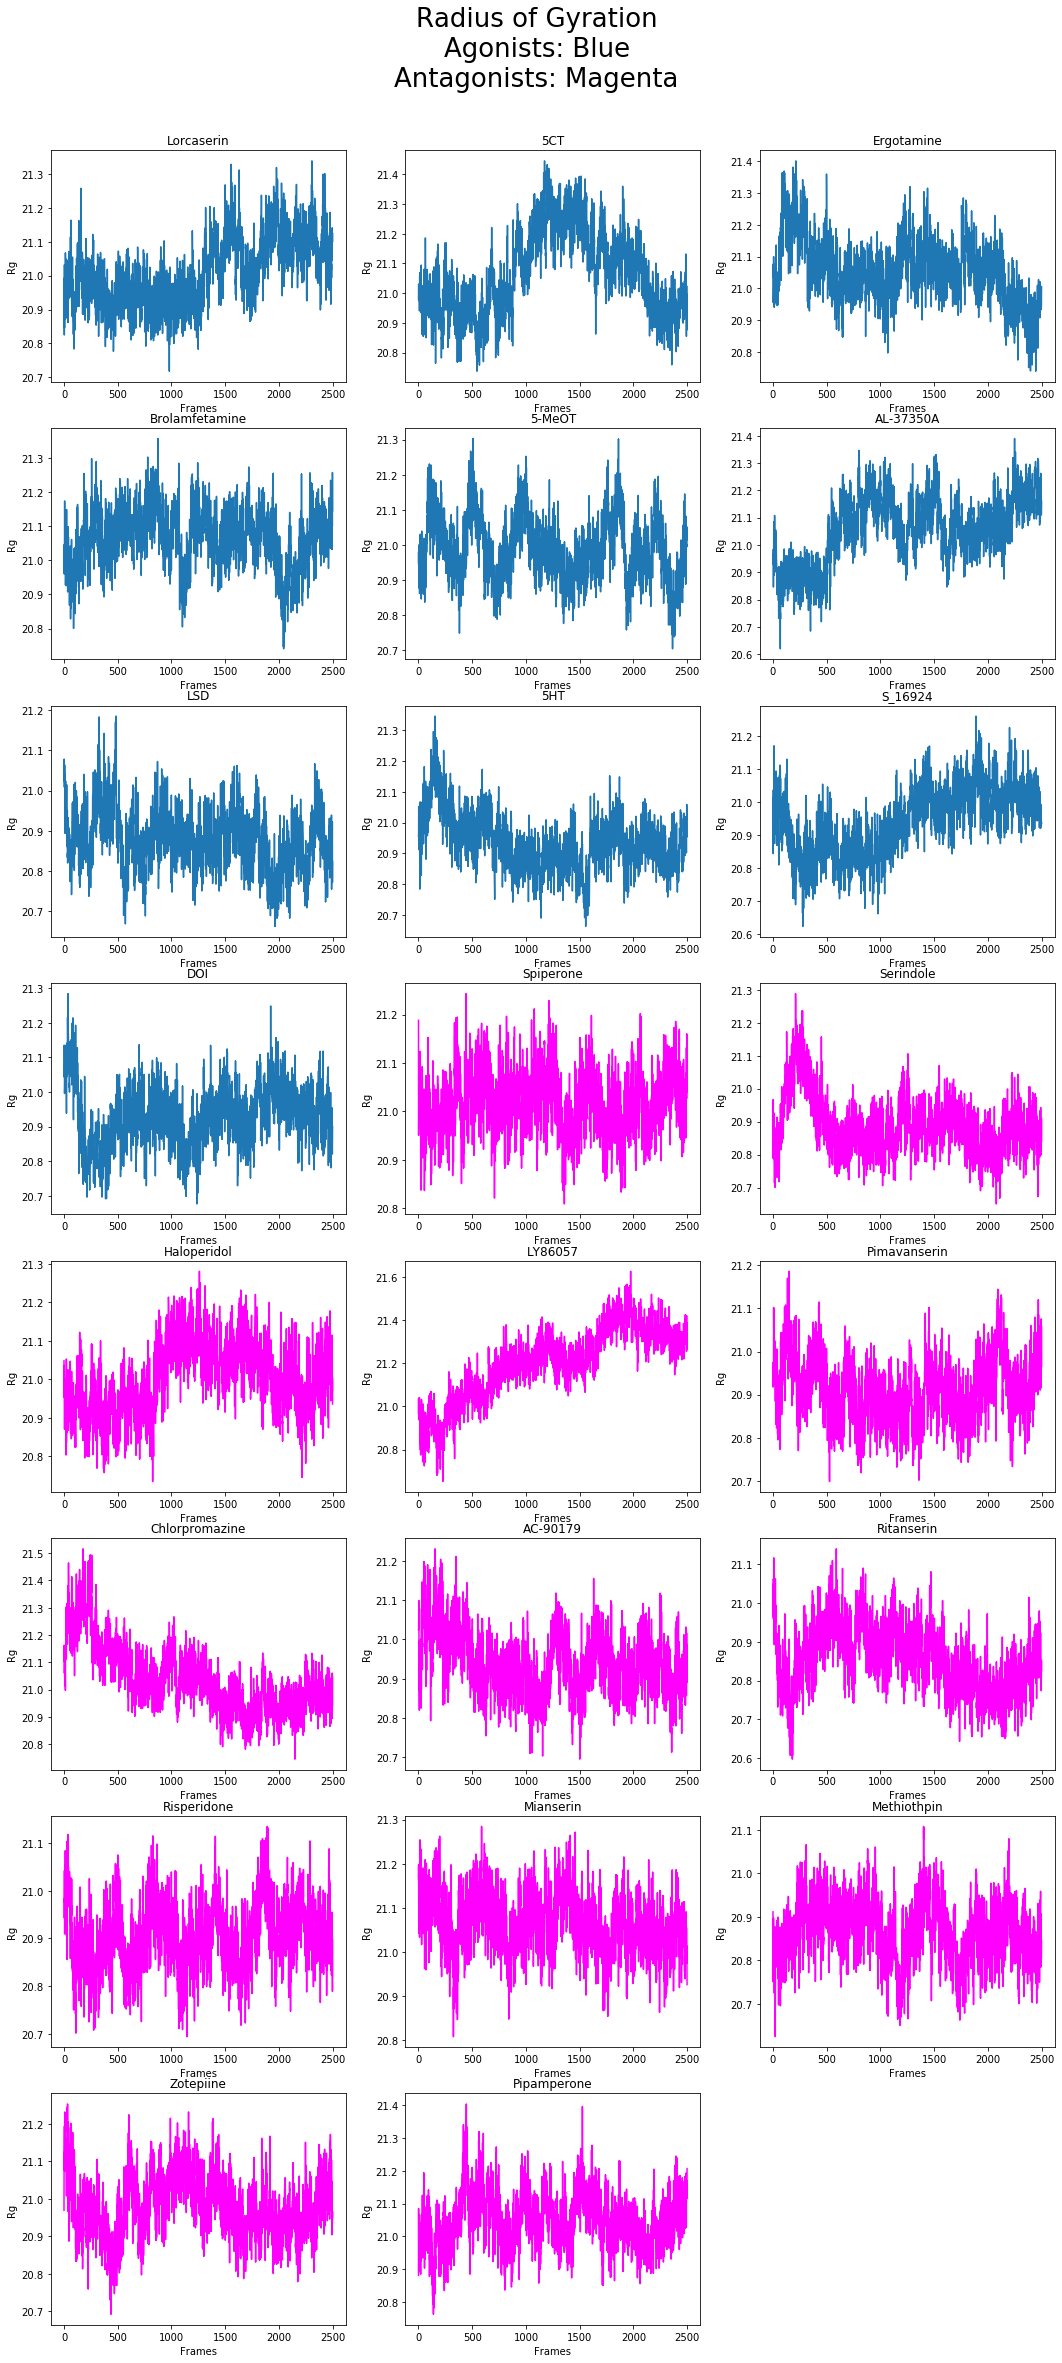

In [6]:
# We create plot of the Rg as frames progress for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].rg_res, label="Rg")
    plt.xlabel("Frames")
    plt.ylabel("Rg")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].rg_res, label="Rg", color='magenta')
    plt.xlabel("Frames")
    plt.ylabel("Rg")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Radius of Gyration\nAgonists: Blue\nAntagonists: Magenta', fontsize=26, y = 0.93)

plt.show()

#### Frame Averaged Plot

To have more intuition if $Rg$ has any important signal for differentiating agonists/antagonists:
1. Create an **average** Rg of each frame of the **agonists**
2. Create an **average** Rg of each frame of the **antagonists**
3. Plot them on the same figure

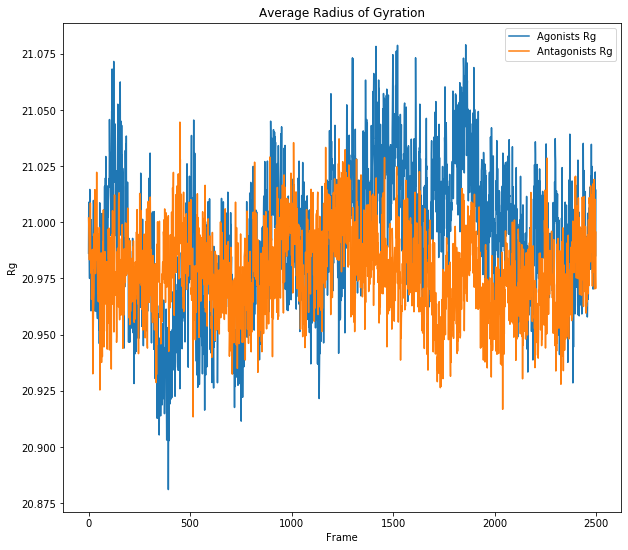

In [7]:
def calculate_average_cols_rg(analysis_actors_dict):
    '''
    Calculates the mean of Rg of each frame for all the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = analysis_actors_dict['Agonists'][0][1].rg_res
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, which_drug[1].rg_res))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = analysis_actors_dict['Antagonists'][0][1].rg_res
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, which_drug[1].rg_res))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_rg_avg, antagon_rg_avg = calculate_average_cols_rg(analysis_actors_dict)

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.plot(np.arange(agon_rg_avg.shape[0]), agon_rg_avg, label="Agonists Rg")
ax.plot(np.arange(agon_rg_avg.shape[0]), antagon_rg_avg, label="Antagonists Rg")
ax.set_ylabel('Rg')
ax.set_xlabel('Frame')

ax.legend()
plt.title("Average Radius of Gyration")
plt.show()


We observe the antagonists not having any great deviations from the average $Rg$ throughout the simulation. However, in the case of the agonists we observe a consistent increase of $Rg$ from frames 1300 - 2100 .

###  Solvent-Accesible Surface Area (SASA)
​  
The accessible surface area (ASA) or solvent-accessible surface area (SASA) is the surface area of a biomolecule that is accessible to a solvent [(ref)](http://compbio.biosci.uq.edu.au/mediawiki/upload/d/d5/Lee1971_JMolBiol55-379.pdf). Measurement of ASA is usually **described in units of square Ångstroms**. ASA is typically calculated using the 'rolling ball' algorithm developed by Shrake & Rupley in 1973. This algorithm uses a sphere (of solvent) of a particular radius to 'probe' the surface of the molecule [(ref)](https://www.sciencedirect.com/science/article/abs/pii/0022283673900119?via%3Dihub).
​  
​  
Changes of SASA indicate a change in the conformation of the protein and unfolding.

<img src="https://drive.google.com/uc?export=view&id=17CHp_-xbBPDuRM13SmvmCMpc4Y1i2jwS" alt="drawing" width="200"/>

*Currently the SASAs were calculated using **GROMACS** before running the notebook. There is a function module on MDTraj package that can be used but my laptop was not able to handle its memory usage. If they were not generated the plots below will fail*

#### Separate Plots

I opted to use the same workflow as I did with $Rg$. So firstly, I will create the separate plots and then combine them on the same plot using the average SASA of each frame.

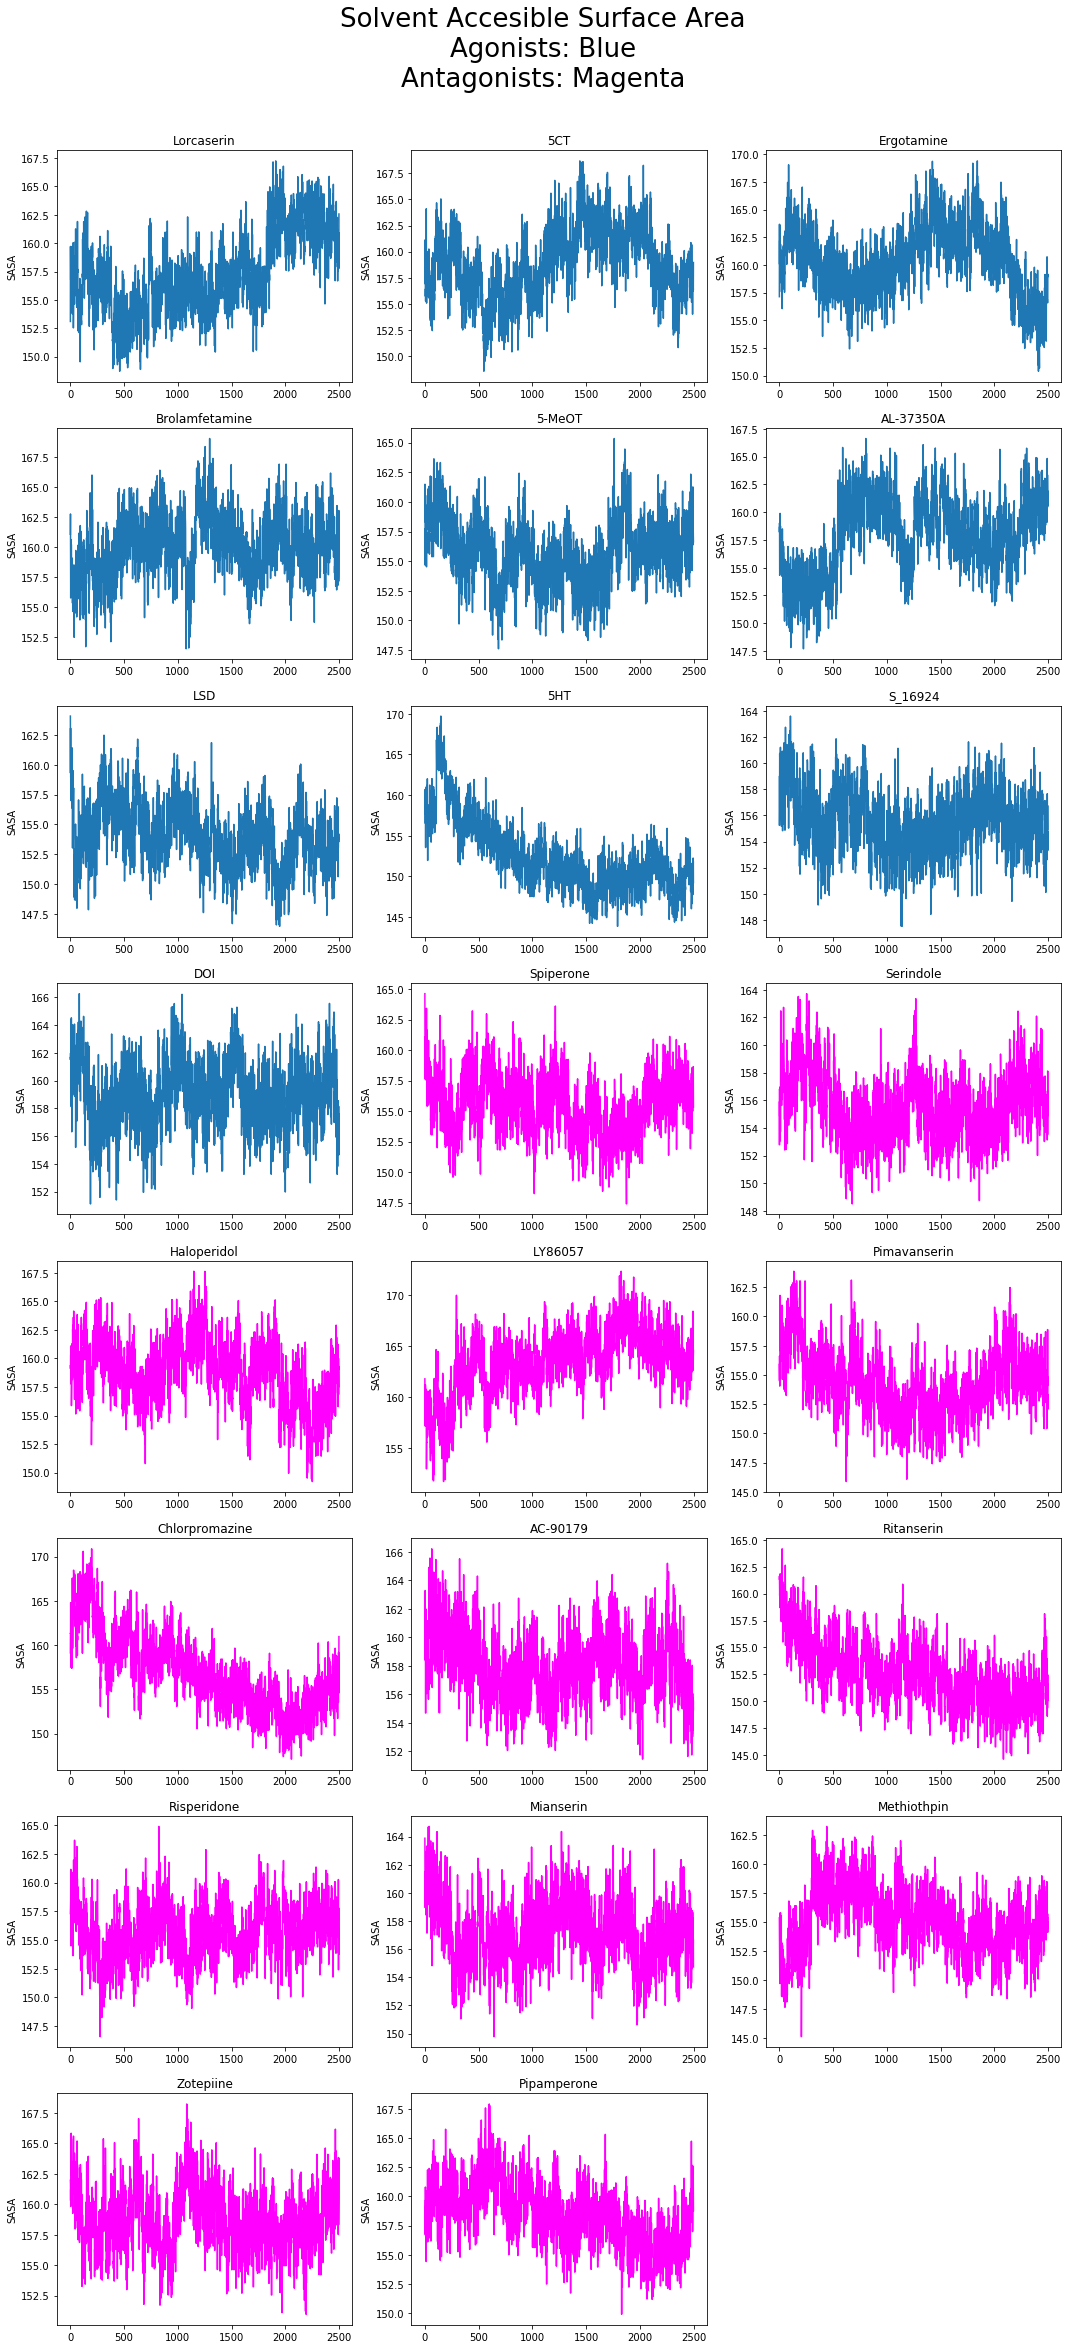

In [8]:
# We create plot of the SASA as frames progress for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].sasa_res[1], label="SASA")
    plt.ylabel("SASA")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].sasa_res[1], label="SASA", color='magenta')
    plt.ylabel("SASA")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Solvent Accesible Surface Area\nAgonists: Blue\nAntagonists: Magenta', fontsize=26, y = 0.93)

plt.show()

#### Frame Averaged Plot

To have more intuition if **SASA** has any important signal for differentiating agonists/antagonists:
1. Create an **average** SASA of each frame of the **agonists**
2. Create an **average** SASA of each frame of the **antagonists**
3. Plot them on the same figure

*TODO: the `calculate_average_cols_metric` methods are similar and should be combined to one more general.* 

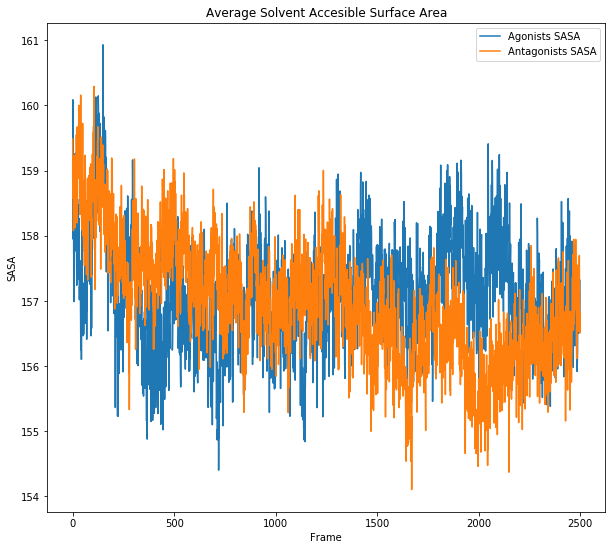

In [9]:
def calculate_average_cols_sasa(analysis_actors_dict):
    '''
    Calculates the mean of SASA of each frame for all the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = analysis_actors_dict['Agonists'][0][1].sasa_res[1]
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, which_drug[1].sasa_res[1]))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = analysis_actors_dict['Antagonists'][0][1].sasa_res[1]
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, which_drug[1].sasa_res[1]))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_sasa_avg, antagon_sasa_avg = calculate_average_cols_sasa(analysis_actors_dict)

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.plot(np.arange(agon_sasa_avg.shape[0]), agon_sasa_avg, label="Agonists SASA")
ax.plot(np.arange(agon_sasa_avg.shape[0]), antagon_sasa_avg, label="Antagonists SASA")
ax.legend()
ax.set_ylabel('SASA')
ax.set_xlabel('Frame')
plt.title("Average Solvent Accesible Surface Area")
plt.show()

This time we observe the agonists have a small increase on their SASA (frames 1800 - 2200). However, this time we also observe the SASA of the antagonists decreasing (frames 1500 - 2200) showing an **inverse correlation** between the $Rg$ of the agonists and the SASA of the antagonists.

### Root Mean Square Flactuation (RMSF)

RMSF is a measure of the deviation of the position of a particle i with respect to a reference position **over time**.

**Difference between RMSD and RMSF**: The latter is averaged over time, giving a value for each particle i. For the RMSD the average is taken over the particles, giving time specific values. So **RMSD is time specific** and **RMSF is atom specific** [(ref)](http://www.drugdesign.gr/uploads/7/6/0/2/7602318/lecture_mdanalysis.pdf).

\begin{equation*}
RMSF_i = \left[ \frac{1}{T} \sum_{t_j=1}^T \mid r_i(t_j) - r_i^\text{ref} \mid ^ 2 \right] ^ \frac{1}{2}
\end{equation*}

$T$ is the total simulation time  
$r_i^\text{ref}$ is the reference position of particle $i$, like the **time-averaged** position of the same particle $i$  

This time since our $x-axis$ are the residues ids, we will have a slightly different approach.
Our $y-axis$ will have the RMSF value of each residue specified by the $x-axis$.
Other than that we will again have the same plots.

#### Separate Plots

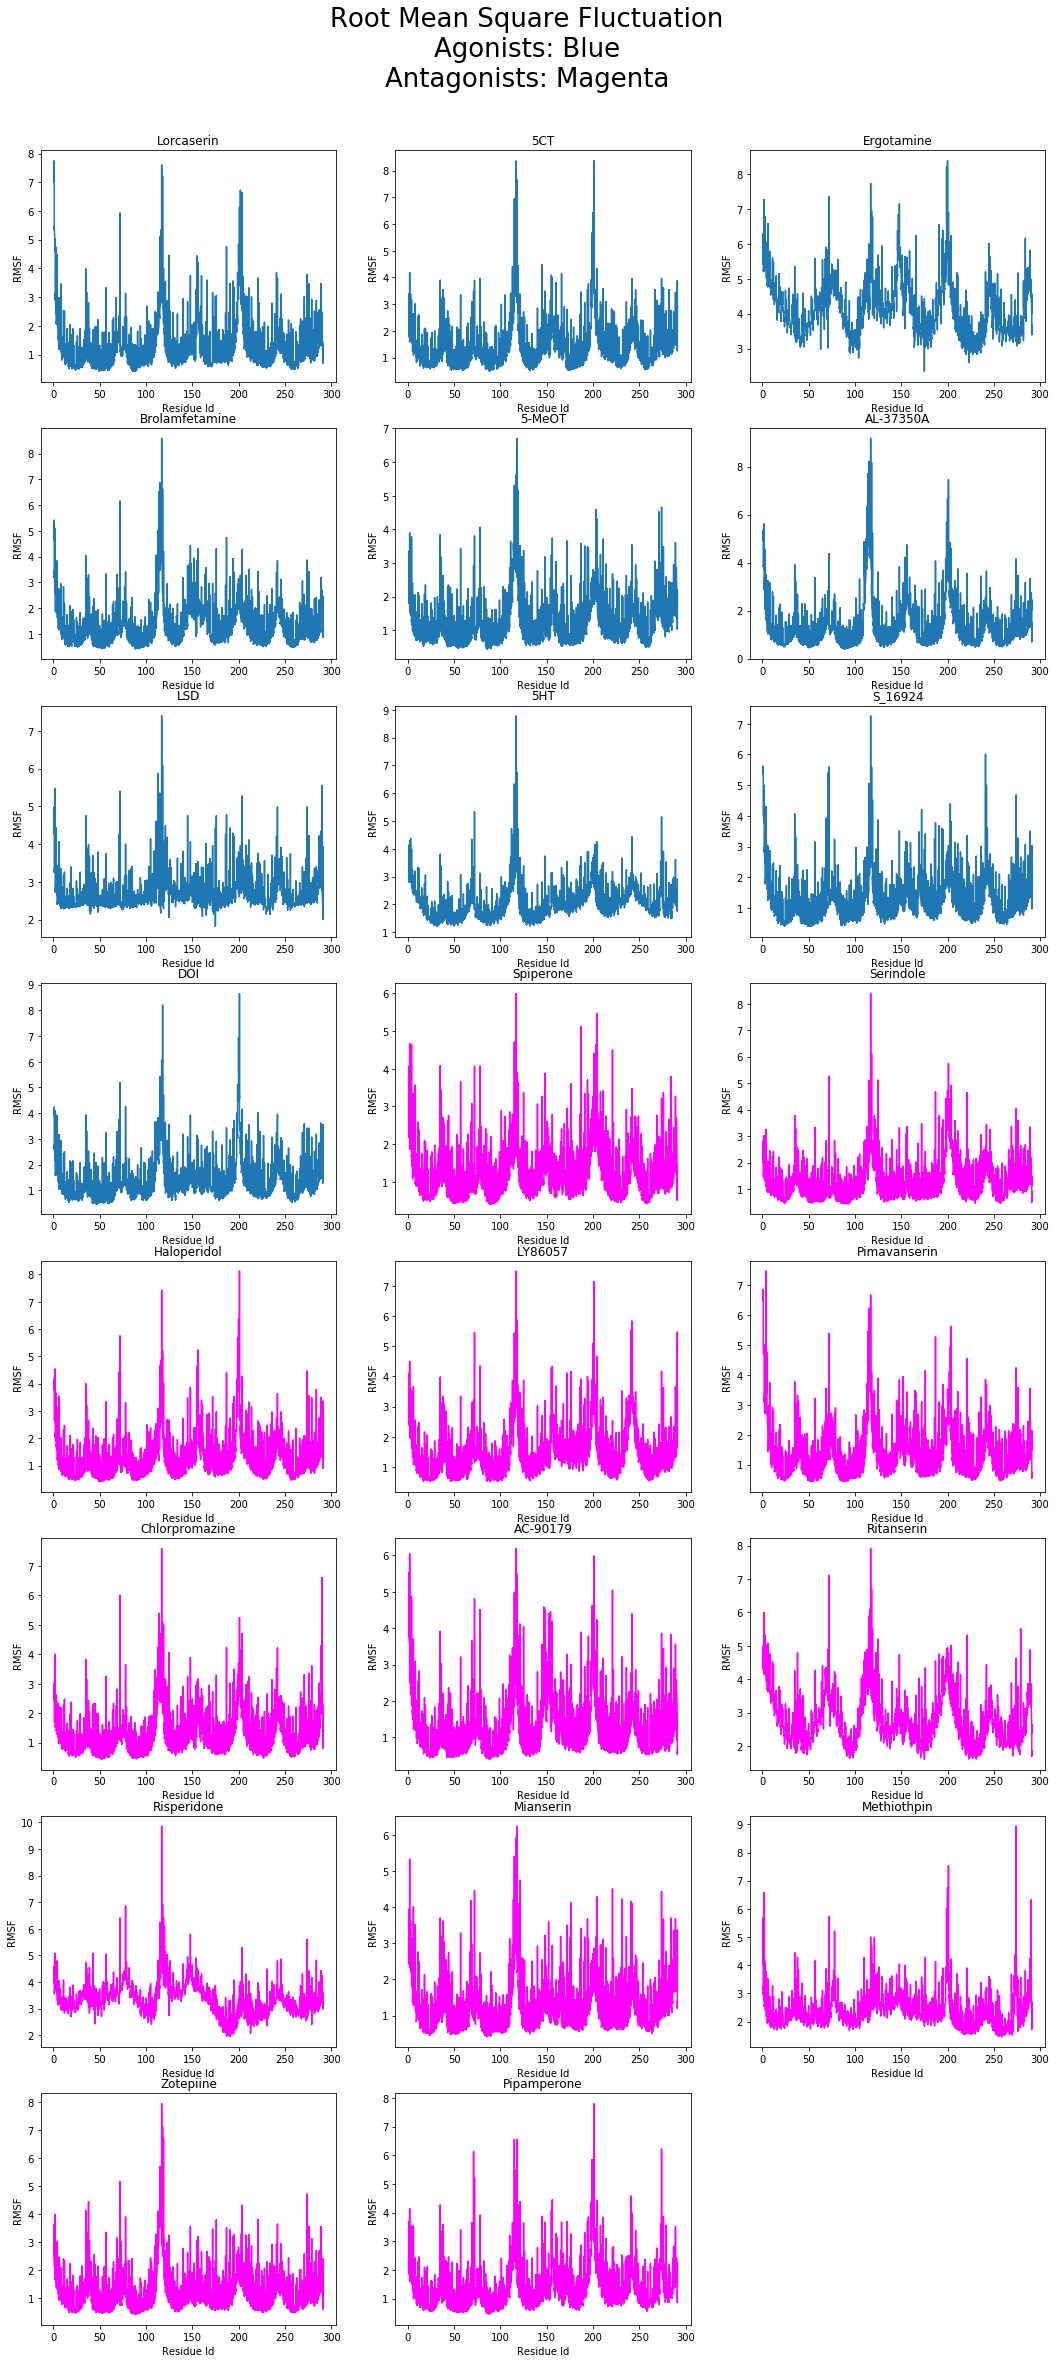

In [10]:
# We create plot of the SASA as frames progress for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(which_drug[1].uni.atoms.resnums, which_drug[1].rmsf_res.rmsf, label="SASA")
#     plt.plot(np.unique(which_drug[1].uni.atoms.resnums), get_avg_rmsf_per_residue(which_drug[1]), label="SASA")
    plt.xlabel("Residue Id")
    plt.ylabel("RMSF")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(which_drug[1].uni.atoms.resnums, which_drug[1].rmsf_res.rmsf, label="SASA", color='magenta')
    plt.xlabel("Residue Id")
    plt.ylabel("RMSF")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Root Mean Square Fluctuation\nAgonists: Blue\nAntagonists: Magenta', fontsize=26, y = 0.93)

plt.show()

#### Residue Averaged Plot

As with the previous plots we average the columns although in this case each column is not a frame but a residue.

Since the dimensions do not much (different number of atoms) I decided to firstly calculate the average RMSF of each residue (which are on all of the drugs 291).
Then I calculate the average RMSF of the residues of all the agonists and then all of the antagonists.

Steps:
1. Calculate for each drug the average RMSF of each residue -> Reduces dimensionality to 291
2. Calculate the average of the result on step 1 for all the agonists
3. Calculate the average of the result on step 1 for all the antagonists
3. Plot them on the same figure


Since the above is a bit complicated I will explain it **using an example**.

Let's say we have 5 agonists.
Each agonist has **k number of atoms** but **291 residues**.  
What residue each atom belongs is given by a vector like: $[1, 1, 1, 2, 2, ..., 291, 291]_k^T$  
We also have a vector of RMSFs of each atom like $[3, 2, 7, 5, 8, ..., 2, 5]_k^T$  
  
We then calculate the average RMSF of each residue. In the above example we will have $(3 + 2 + 7)/3$ for residue1    
Since we have 291 residues, this creates a vector of 291 values.  
We do this for all the agonists, stack them and calculate the average the same way we did on $Rg$ and SASA.

In [11]:
def get_avg_rmsf_per_residue(drug):
    '''
    Having the series of resnumbs eg [1, 1, 1, 2, 2, ..., 291, 291] and their respective
    RMSF crete buckets (each bucket represents a residue) and calculate the average 
    RMSF of each residue
    
    Args:
        drug (AnalysisActor.class): The AnalysisActor object on which we have calculated the RMSF
    
    Returns:
        np.array[#unique_resnumbs]: The average RMSF of each residue
    '''
    bucket = 0
    total_rmsf = np.zeros(len(np.unique(drug.uni.atoms.resnums)))    # Holds the sum of RMSFs of each residue
    total_atoms = np.zeros(len(np.unique(drug.uni.atoms.resnums)))   # Holds the number of atoms of each residue
    first_time = True
    for i in range(len(drug.uni.atoms.resnums)):
        if not first_time and drug.uni.atoms.resnums[i] != drug.uni.atoms.resnums[i - 1]:
            bucket += 1    # Changed residue -> go to next bucket
        elif first_time:
            first_time = False

        total_rmsf[bucket] += drug.rmsf_res.rmsf[i]
        total_atoms[bucket] += 1

    avg_rmsf_per_residue = total_rmsf / total_atoms    # Calculate the mean

    return avg_rmsf_per_residue

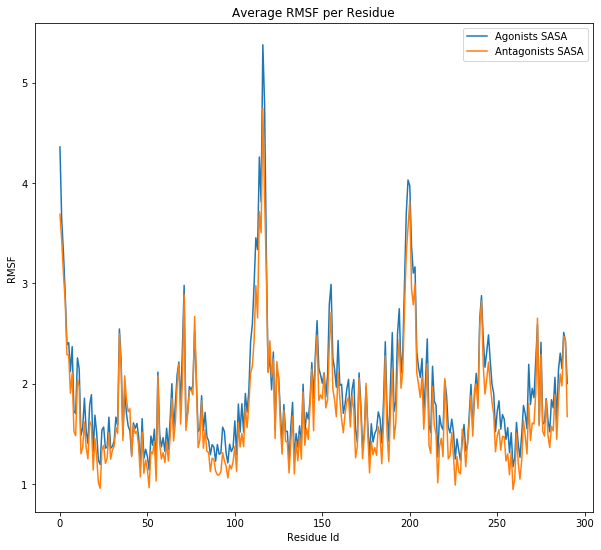

In [12]:
def calculate_average_cols_rmsf(analysis_actors_dict):
    '''
    Calculates the mean of the mean residue RMSF for the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = get_avg_rmsf_per_residue(analysis_actors_dict['Agonists'][0][1])
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, get_avg_rmsf_per_residue(which_drug[1])))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = get_avg_rmsf_per_residue(analysis_actors_dict['Antagonists'][0][1])
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, get_avg_rmsf_per_residue(which_drug[1])))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_rmsf_residue_avg, antagon_rmsf_residue_avg = calculate_average_cols_rmsf(analysis_actors_dict)

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.plot(np.arange(agon_rmsf_residue_avg.shape[0]), agon_rmsf_residue_avg, label="Agonists SASA")
ax.plot(np.arange(agon_rmsf_residue_avg.shape[0]), antagon_rmsf_residue_avg, label="Antagonists SASA")
ax.legend()
ax.set_ylabel('RMSF')
ax.set_xlabel('Residue Id')
plt.title("Average RMSF per Residue")
plt.show()